In [93]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.dpi']= 200
X_train = pd.read_csv("X_train.csv", header=None).to_numpy()
y_train = pd.read_csv("y_train.csv", header=None).to_numpy()
X_test = pd.read_csv("X_test.csv", header=None).to_numpy()
y_test = pd.read_csv("y_test.csv", header=None).to_numpy()

In [256]:
## AUTOENCODR MODEL
class autoencoder(nn.Module):
    def __init__(
        self,
        X=None,
        y=None,
        max_iter=10_000,
        learning_rate=0.001,
        init_scale=1,
        batch_size=1,
        weight_decay=0.001,
        device=None,
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.init_scale = init_scale
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.device = device

        if X is not None and y is not None:
            self.fit(X,y)
    
    def build(self, in_out_dim):
        layers = []
        layers.append(nn.Linear(in_out_dim, 500))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(500, 250))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(250, 2))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(2, 250))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(250, 500))
        layers.append(nn.Tanh())
        layers.append(nn.Linear(500, in_out_dim))

        self.layers = nn.Sequential(*layers)


    def forward(self, x):
        return self.layers.forward(self.tensorize(x))

    def tensorize(self, ary):
        return torch.as_tensor(ary, dtype=torch.get_default_dtype(), device=self.device)

    def fit(self, X, y):
        X = self.tensorize(X)
        y = self.tensorize(y)

        self.build(X.shape[1])
        loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        for i in range(self.max_iter):
            self.optimizer.zero_grad()
            # forward
            inds = torch.as_tensor(np.random.choice(X.shape[0], size=self.batch_size, replace=False))
            output = self(X[inds,:])
            loss = loss_fn(output, X[inds,:])
            # backward
            loss.backward()
            self.optimizer.step()

            if i % 500 == 0:
                print(f"Iteration {i:>10,}: loss = {loss:>6.3f}")

In [257]:
## FITTING AND "PREDICTING" (more like calculating reconstruction errors)
model = autoencoder()
model.fit(X_train, y_train)
with torch.no_grad():
    tensor_x_test = model.tensorize(X_test)
    test_output = model(tensor_x_test)
    recon_loss = nn.MSELoss()(test_output, tensor_x_test)
recon_loss

Iteration          0: loss = 59.032
Iteration        500: loss = 59.230
Iteration      1,000: loss = 58.397
Iteration      1,500: loss = 58.069
Iteration      2,000: loss = 57.526
Iteration      2,500: loss = 57.003
Iteration      3,000: loss = 56.385
Iteration      3,500: loss = 56.184
Iteration      4,000: loss = 55.133
Iteration      4,500: loss = 54.167
Iteration      5,000: loss = 52.754
Iteration      5,500: loss = 51.659
Iteration      6,000: loss = 50.262
Iteration      6,500: loss = 48.863
Iteration      7,000: loss = 48.033
Iteration      7,500: loss = 46.766
Iteration      8,000: loss = 45.751
Iteration      8,500: loss = 44.007
Iteration      9,000: loss = 43.143
Iteration      9,500: loss = 42.031


tensor(40.6203)

In [172]:
# for learning rate = 0.001 and weight decay = 0.01, then lr of 0.011, and weight of 0.001, then lr 0.01, weight 0.01
# test set recon loss for 10k iters: 41.6109, 0.9738
# test set recon loss for 20k iters: 25.6221, 0.5476, 4.5772
# test set recon loss for 30k iters: 16.8767, 
# test set recon loss for 40k iters: 12.2554, 

In [ ]:
# learning rate = 0.001, weight decay of 0.001
# test set recon loss for 10k: 40.620
# test set recon loss for 20k: 23.4804

In [258]:
## GETTING LATENT REPRESENTATIONS OF THE DATASET & SAVING (AND SAVING MODEL TOO)
X_train_latent= model.layers[:6](model.tensorize(X_train)).detach().numpy()
X_test_latent = model.layers[:6](model.tensorize(X_test)).detach().numpy()
X_total_latent = np.concatenate((X_train_latent, X_test_latent), axis=0)
np.savetxt("total_latent_variables_10k.csv", X_total_latent, delimiter=",")
np.savetxt("train_latent_variables_10k.csv", X_train_latent, delimiter=",")
np.savetxt("test_latent_variables_10k.csv", X_test_latent, delimiter=",")
torch.save(model.state_dict(), './sim_10k_autoencoder.pth')

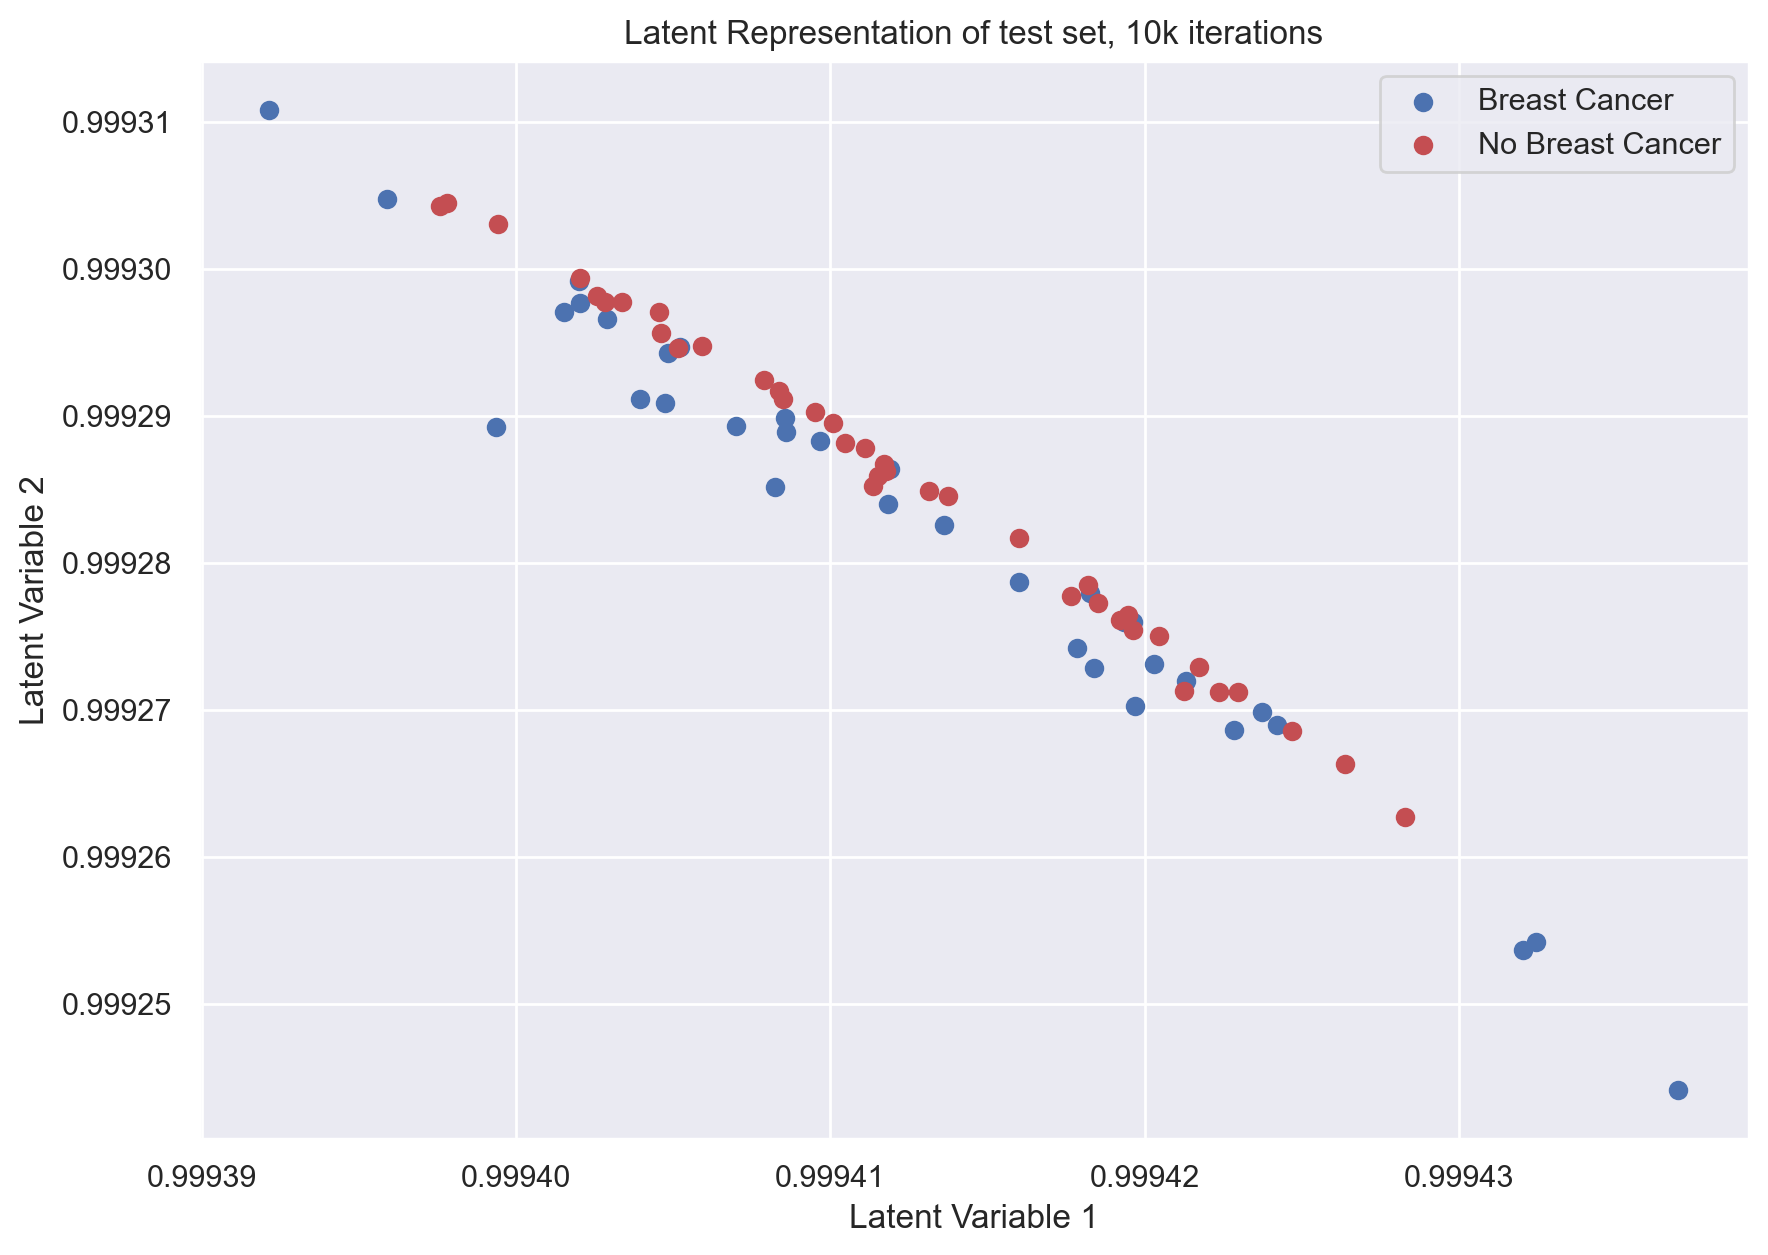

In [261]:
## PLOTTING THE LATENT REPRESENTATIONS
y = np.concatenate((y_train, y_test), axis=0)

sns.set(rc={"figure.figsize":(10,7)})
class1_mask = (y_test == 0)[:,0]  # a boolean mask for class 1
class2_mask = (y_test == 1)[:,0]  # a boolean mask for class 2

# plot the points for class 1 in blue
# plot the points for class 2 in red
plt.scatter(X_test_latent[class1_mask,0], X_test_latent[class1_mask,1], c='b', label='Breast Cancer')
plt.scatter(X_test_latent[class2_mask,0], X_test_latent[class2_mask,1], c='r', label='No Breast Cancer')
plt.xlabel("Latent Variable 1")
plt.ylabel("Latent Variable 2")
plt.title("Latent Representation of test set, 10k iterations")
plt.legend()
plt.show()

In [246]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb

In [249]:
depths = np.int64(np.linspace(1, 50, 25, endpoint=True))
rfc_cv_scores = []
rfc_models = []
for depth in depths:
    rfc = RandomForestClassifier(max_depth=depth, n_estimators=15, max_features=1, bootstrap=True, random_state=0) # check what random state's for
    score = np.mean(cross_val_score(rfc, X_train_latent, y_train[:,0], cv=5))
    print("depth " + str(depth) + ": " + str(score))
    rfc_cv_scores = rfc_cv_scores + [score]
    rfc_models = rfc_models + [rfc]
rfc_optim_model = rfc_models[np.argmax(rfc_cv_scores)]
rfc_optim_model.fit(X_train_latent, y_train[:,0])
rfc_optim_model.score(X_test_latent, y_test[:,0])

depth 1: 0.5278012684989429
depth 3: 0.5372093023255815
depth 5: 0.6063424947145878
depth 7: 0.6157505285412262
depth 9: 0.6020084566596194
depth 11: 0.5973572938689218
depth 13: 0.5974630021141649
depth 15: 0.5975687103594081
depth 17: 0.5929175475687104
depth 19: 0.5929175475687104
depth 21: 0.5929175475687104
depth 23: 0.5929175475687104
depth 25: 0.5929175475687104
depth 27: 0.5929175475687104
depth 29: 0.5929175475687104
depth 31: 0.5929175475687104
depth 33: 0.5929175475687104
depth 35: 0.5929175475687104
depth 37: 0.5929175475687104
depth 39: 0.5929175475687104
depth 41: 0.5929175475687104
depth 43: 0.5929175475687104
depth 45: 0.5929175475687104
depth 47: 0.5929175475687104
depth 50: 0.5929175475687104


0.7123287671232876

In [250]:
estimators = [1, 5, 15, 25, 50, 75]
ada_cv_scores = []
ada_models = []
for estimator in estimators:
    abc = AdaBoostClassifier(n_estimators=estimator)    
    score = np.mean(cross_val_score(abc, X_train_latent, y_train[:,0], cv=5))
    print("estimator " + str(estimator) + ": " + str(score))
    ada_cv_scores = ada_cv_scores + [score]
    ada_models = ada_models + [abc]
ada_optim_model = ada_models[np.argmax(ada_cv_scores)]
ada_optim_model.fit(X_train_latent, y_train[:,0])
ada_optim_model.score(X_test_latent, y_test[:,0])

estimator 1: 0.5183932346723045
estimator 5: 0.5692389006342495
estimator 15: 0.6019027484143764
estimator 25: 0.6438689217758985
estimator 50: 0.6342494714587739
estimator 75: 0.6435517970401692


0.7534246575342466

In [251]:
params = {'learning_rate': [0.1, 0.01, 0.001],
            'max_depth': [5, 10, 15, 20, 25, 30],
            'n_estimators': [100, 200, 300, 400, 500],
            'subsample': [0.5, 0.7, 0.9],
            'colsample_bytree': [0.5, 0.7, 0.9],
            'reg_alpha': [0, 0.1, 0.5, 1],
            'reg_lambda': [0, 0.1, 0.5, 1]}
xgb_model = xgb.XGBClassifier()
rs_classifier = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, cv=5, n_jobs=-1)
rs_classifier.fit(X_train_latent, y_train[:,0])
xgb_optim_model = xgb.XGBClassifier(**rs_classifier.best_params_)
xgb_optim_model.fit(X_train_latent, y_train[:,0])
xgb_optim_model.score(X_test_latent, y_test[:,0])

0.6027397260273972

In [255]:
rf_auc = round(roc_auc_score(y_test, rfc_optim_model.predict_proba(X_test_latent)[:,1]), 3)
ada_auc = round(roc_auc_score(y_test, ada_optim_model.predict_proba(X_test_latent)[:,1]), 3)
xgb_auc = round(roc_auc_score(y_test, xgb_optim_model.predict_proba(X_test_latent)[:,1]), 3)
rf_auc, ada_auc, xgb_auc

(0.793, 0.782, 0.671)